<a href="https://colab.research.google.com/github/UgurUysal86/MLS4MIL/blob/master/Image%20Classification/code/Finetuning_a_pretrained_image_classification_model_with_a_syntethic_image_dataset_to_detect_different_types_of_tanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Ugur Uysal](https://github.com/UgurUysal86) - ugur.uysal.86@gmail.com - 03. JUNE 2024

## Finetuning a pretrained image classification model with a syntethic image dataset to detect different types of tanks

The purpose of training a classifier on the 5RuTanks syntethic dataset is to create a model that can classify images as "BMP2", "Buk-M1-2", "T14", "T90", or "ZSU23", described by the GitHub Repository [Machine Learning and Simulation for Military Applications](https://github.com/UgurUysal86/MLS4MIL/tree/master/Image%20Classification)

All training images (7000 per class) were created synthetically with the game engine [Arma3](https://arma3.com/). The 75 validation images are real images publicly available and provided under creative commons licenses. A full reference of all validation Images is provided in the Reference Section of this notebook and in the GitHub Repository above. The dataset will be directly download to this notebook in cell 1.2.

## Purpose of this notebook:
This notebook demonstrates the process of Finetuning a pretrained neural network-based image classification model utilizing tensorflow.keras on the 5RuTanks syntethic dataset.

# Part 1. Preparing the colab environment and the dataset

## 1.1 Checking GPU availablity

The following code checks if a GPU is available for use in a Google Colab environment. It imports the TensorFlow library and the device_lib module, then iterates through the available devices to check for a GPU. If a GPU is found, its details are printed.

In [ ]:
import tensorflow as tf
print("Using Tensorflow Version", tf.__version__, "\n")

# validating COLAB GPU
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
   if x.device_type == "GPU":
     print("***** GPU Information *****")
     print("Device Name: " , x.name)
     print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB")
     print("Description: " , x.physical_device_desc)

Using Tensorflow Version 2.15.0 

***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  21.99 GB
Description:  device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


## 1.2 Downloading and preprocessing the "5RuTanks_synthetic_dataset" Dataset as zipfile from Google Drive and saving temporary in Colab

In [ ]:
!wget --no-check-certificate \
    "https://drive.usercontent.google.com/download?id=14SLtuDJCQfgflfUb6eLyN-zeVYe4BeVq&export=download&confirm=yes" \
    -O /content/5RuTanks_synthetic_dataset.zip

import zipfile
print ("Loading dataset ...")
local_zip = '/content/5RuTanks_synthetic_dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()
print ("Dataset successfully loaded and unzipped")

--2024-06-04 01:53:18--  https://drive.usercontent.google.com/download?id=14SLtuDJCQfgflfUb6eLyN-zeVYe4BeVq&export=download&confirm=yes
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574656103 (548M) [application/octet-stream]
Saving to: ‘/content/5RuTanks_synthetic_dataset.zip’

/content/5RuTanks_s 100%[===================>] 548.03M  74.9MB/s    in 9.1s    

2024-06-04 01:53:27 (60.0 MB/s) - ‘/content/5RuTanks_synthetic_dataset.zip’ saved [574656103/574656103]

Loading dataset ...
Dataset successfully loaded and unzipped


## 1.3 Setting dataset paths

The code below sets up paths for the synthetic image dataset (training and validation sets) and counts the number of images in each set. It uses the os module to interact with directories and prints the total loaded images for training and validation.

In [ ]:
import os
dataset_path = '/content/5RuTanks_synthetic_dataset/'
train_images_path = dataset_path + 'training/'
val_images_path = dataset_path + 'validation/'
test_images_path = dataset_path + 'test/' # Placeholder if testdata is added later (not provided with the dataset)

nbrTrainImages = 0  # Value gets accurate after counting (Total Number of train images)
for ImagesClass in os.listdir(train_images_path):
    nbrTrainImages += len(os.listdir(train_images_path+ImagesClass))
print(nbrTrainImages, "train images loaded")

nbrValImages = 0  # Value gets accurate after counting (Total Number of val images)
for ImagesClass in os.listdir(val_images_path):
    nbrValImages += len(os.listdir(val_images_path+ImagesClass))
print(nbrValImages, "val images loaded")

35000 train images loaded
75 val images loaded


## 1.4 Inspecting the Datasat by Visualizing random images

The code below generates a visual representation of random images from different classes of the dataset.

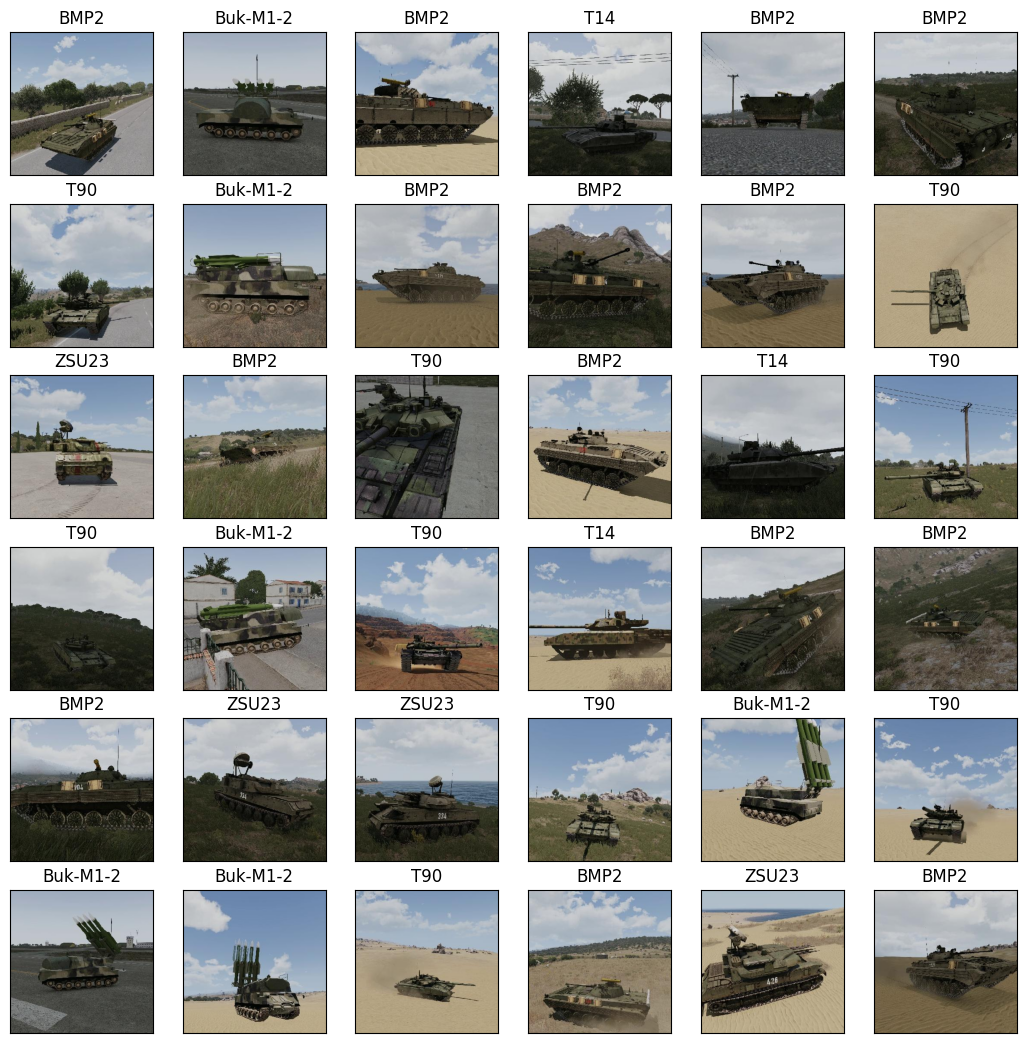

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
np.set_printoptions(suppress=True)

classnames = ["BMP2","Buk-M1-2","T14","T90","ZSU23"]

samples = []
for i in range(36):
  rnd_class = np.random.randint(len(classnames), size=1)
  rnd_img = np.random.randint(7000, size=1)
  img = train_images_path+classnames[rnd_class[0]]+'/'+classnames[rnd_class[0]]+'_'+str(rnd_img[0])+'.jpg'
  samples.append(img)

plt.figure(figsize=(13,13))
for i in range(len(samples)):
    plt.subplot(6,6,i+1)
    plt.imshow(mpimg.imread(samples[i]))
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])
    if classnames[0] in samples[i]:plt.title(classnames[0])
    if classnames[1] in samples[i]:plt.title(classnames[1])
    if classnames[2] in samples[i]:plt.title(classnames[2])
    if classnames[3] in samples[i]:plt.title(classnames[3])
    if classnames[4] in samples[i]:plt.title(classnames[4])
plt.show()

# Part 2: Training the model. Reference: https://keras.io/guides/transfer_learning/



## 2.1 Setting Hyper Parameters

The hyperparameters for training your model include image dimensions of 300x300 pixels, a maximum of 250 training epochs, a learning rate of 0.000025, a batch size of 16 samples, dropout regularization with a rate of 0.3, a first fully connected layer of 32 neurons, early stopping patience of 5 epochs, and detailed output during training

In [ ]:
# hyperparameters
img_height, img_width = 300, 300  # expected shape of the pretrained model EfficientNetV2B3
MAX_EPOCHS = 250
LEARNING_RATE = 0.000025
BATCHSIZE = 16
DROPOUT = 0.3   # 0.2 - 0.5
fcLayer1 = 32
patience = 5
factor = 0.5
verbose_train = 1
print("Training parameters set")

Training parameters set


## 2.2 Implementing Datagenerators with Data Augmentation. Reference: https://keras.io/preprocessing/image/

This code snippet sets up data generators for training and validation using the ImageDataGenerator class from TensorFlow/Keras. It applies various data augmentation techniques (e.g., rotation, shifts, zoom, brightness) to enhance the training data. The generators load images from specified directories (train_images_path and val_images_path) and prepare them for training and evaluation.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_images_path,
    target_size=(img_height, img_width),
    batch_size=BATCHSIZE,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)
val_generator = val_datagen.flow_from_directory(
    val_images_path,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=False,
    classes=classnames,
    class_mode='categorical')

Found 35000 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


## 2.3 Loading the pretrained model EfficientNetV2B3 as foundation model

The provided code instantiates an EfficientNetV2B3 model with pretrained weights from ImageNet. It excludes the top classification layer and sets the input shape to 300x300 pixels with 3 color channels. The summary displays model architecture, and the printed line calculates the number of trainable layers.

In [ ]:
foundation_model = tf.keras.applications.EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))  # expected shape=(None, 300, 300, 3)
foundation_model.summary()
print ("\ntrainable layers of the foundation model: ",int(len(foundation_model.trainable_weights) / 2))

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 40)         1080      ['normalizatio

## 2.4 creating the model including the foundation model

The provided code snippet accomplishes the following: The foundation model is frozen, a new model is built using the pretrained foundation model, and it is compiled for training with specific loss, optimizer, and metrics settings.

In [ ]:
# freezing the foundation model
foundation_model.trainable = False

# Building the model using the pretrained model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = foundation_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(DROPOUT)(x)
x = tf.keras.layers.Dense(fcLayer1, activation=tf.nn.relu)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(len(classnames), activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

print("trainable layers after freezing the foundation model:", int(len(model.trainable_weights)/2))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 10, 10, 1536)      12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 batch_normalization (Batch  (None, 32)                128   

## 2.5 Training the top of the model (added layers on top of the foundation model)

The provided code snippet sets up two callbacks for training the model: EarlyStopping monitors validation loss, restores best weights, and stops training if no improvement is observed within (patience*2)+1 epochs, while ReduceLROnPlateau adjusts the learning rate when validation loss plateaus with a specified reduction factor and patience. The model is then trained using the specified generators and parameters, and successful completion is indicated.

In [ ]:
callbacks_L1 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=(patience*2)+1, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)]

print("\n### Training the newly added top of the model")
history_L1 = model.fit(
    train_generator,
    steps_per_epoch=nbrTrainImages // (BATCHSIZE * 50),
    epochs=MAX_EPOCHS,
    callbacks=callbacks_L1,
    validation_data=val_generator,
    validation_steps=nbrValImages,
    verbose=verbose_train)

print("\n### Training the newly added top of the model finished successfully ###")


### Training the newly added top of the model
Epoch 1/250
43/43 [==============================] - 31s 425ms/step - loss: 1.9990 - acc: 0.2500 - val_loss: 1.6555 - val_acc: 0.2533 - lr: 2.5000e-05
Epoch 2/250
43/43 [==============================] - 16s 363ms/step - loss: 1.8964 - acc: 0.2762 - val_loss: 1.6254 - val_acc: 0.2800 - lr: 2.5000e-05
Epoch 3/250
43/43 [==============================] - 16s 362ms/step - loss: 1.7847 - acc: 0.3081 - val_loss: 1.5772 - val_acc: 0.3333 - lr: 2.5000e-05
Epoch 4/250
43/43 [==============================] - 16s 365ms/step - loss: 1.6505 - acc: 0.3387 - val_loss: 1.5317 - val_acc: 0.3733 - lr: 2.5000e-05
Epoch 5/250
43/43 [==============================] - 16s 363ms/step - loss: 1.4867 - acc: 0.4201 - val_loss: 1.4750 - val_acc: 0.4400 - lr: 2.5000e-05
Epoch 6/250
43/43 [==============================] - 16s 368ms/step - loss: 1.4835 - acc: 0.4113 - val_loss: 1.4163 - val_acc: 0.4400 - lr: 2.5000e-05
Epoch 7/250
43/43 [============================

## 2.6 Plotting Training and Validation Metrics per Epoch (during Training the top of the model)

The provided code evaluates the accuracy and loss during training of the top layers in the model. It plots both training and validation accuracy over the epochs, as well as the corresponding loss. The blue dots represent training data, while the red dots represent validation data. These visualizations help monitor the model’s performance during training.

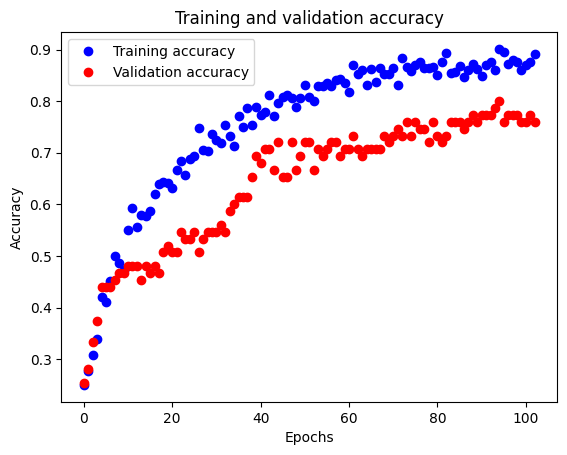

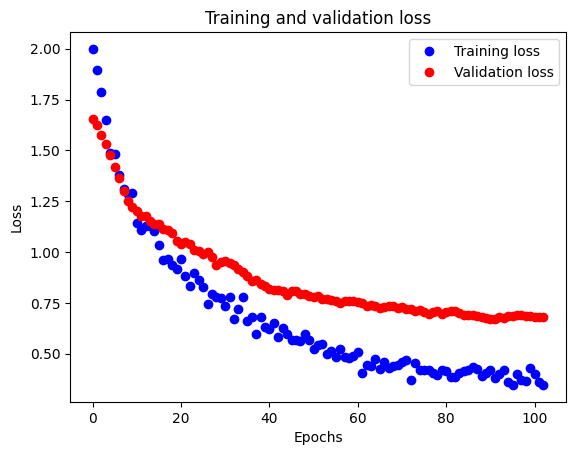

In [ ]:
# Evaluating Accuracy and Loss for Training the top of the model
acc      = history_L1.history['acc']
val_acc  = history_L1.history['val_acc']
loss     = history_L1.history['loss' ]
val_loss = history_L1.history['val_loss']
epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.7 Setting up the model for Fine Tuning including the foundation model

The provided code snippet adjusts the foundation model’s trainable layers based on the specified freezeUptoLayer. If no specific layer is chosen (freezeUptoLayer == ""), the entire foundation model is fully unfrozen. Otherwise, only layers up to the specified layer are unfrozen. The model is then compiled with a reduced learning rate, and its performance is evaluated before further training.

In [ ]:
# unfreezing the foundation model up to a specific layer:
freezeUptoLayer = ""   # choose a specific layer (e.g. "block2a_expand_conv") or fully unfreeze the foundation model with ""

if freezeUptoLayer == "":
    foundation_model.trainable = True
    print ("\ntrainable layers after fully unfreezing the foundation model: ",int(len(model.trainable_weights) / 2))
else:
    print("\ntrainable layers before unfreezing the foundation model up from " + freezeUptoLayer + ": ",int(len(model.trainable_weights) / 2))  # weights = weights + bias = 2 pro layer
    foundation_model.trainable = True
    set_trainable = False
    for layer in foundation_model.layers:
        if layer.name == freezeUptoLayer: set_trainable = True
        if set_trainable: layer.trainable = True
        else: layer.trainable = False
    print("trainable layers after unfreezing the foundation model up from " + freezeUptoLayer + ": ", int(len(model.trainable_weights)/2))

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE/2), metrics=['acc'])

print('\nvalidating model before training unfreezed layers and trained densely connected layers:')
val_loss, val_acc = model.evaluate(val_generator, steps=nbrValImages, verbose=1)
print('Validation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")


trainable layers after fully unfreezing the foundation model:  183

validating model before training unfreezed layers and trained densely connected layers:
75/75 [==============================] - 5s 14ms/step - loss: 0.6722 - acc: 0.7733
Validation loss: 0.6722320914268494 , Validation accuracy: 0.7733333110809326 



## 2.8 Training (Fine Tuning) the model including foundation model

The provided code snippet sets up two callbacks for fine-tuning the model during training: EarlyStopping monitors validation loss, restores best weights, and stops training if no improvement is observed within (patience*2)+1 epochs, while ReduceLROnPlateau adjusts the learning rate when validation loss plateaus with a specified reduction factor and patience. The model is then fine-tuned using the specified generators and parameters, and successful completion is indicated.

In [ ]:
callbacks_L2 = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=(patience*2)+1, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)]

print("\n### Training (Fine-Tuning) ... ")
history_L2 = model.fit(
    train_generator,
    steps_per_epoch=nbrTrainImages // (BATCHSIZE * 50),
    epochs=MAX_EPOCHS,
    callbacks=callbacks_L2,
    validation_data=val_generator,
    validation_steps=nbrValImages,
    verbose=verbose_train)

print("\n### Training (Fine-Tuning) finished successfully ###")
val_loss, val_acc = model.evaluate(val_generator, steps=nbrValImages, verbose=1)
print('Validation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")


### Training (Fine-Tuning) ... 
Epoch 1/250
43/43 [==============================] - 61s 355ms/step - loss: 0.3243 - acc: 0.8983 - val_loss: 0.6539 - val_acc: 0.7467 - lr: 1.2500e-05
Epoch 2/250
43/43 [==============================] - 16s 368ms/step - loss: 0.2532 - acc: 0.9288 - val_loss: 0.5988 - val_acc: 0.8400 - lr: 1.2500e-05
Epoch 3/250
43/43 [==============================] - 16s 365ms/step - loss: 0.2058 - acc: 0.9419 - val_loss: 0.5910 - val_acc: 0.8267 - lr: 1.2500e-05
Epoch 4/250
43/43 [==============================] - 16s 364ms/step - loss: 0.1435 - acc: 0.9666 - val_loss: 0.5741 - val_acc: 0.8400 - lr: 1.2500e-05
Epoch 5/250
43/43 [==============================] - 16s 358ms/step - loss: 0.1061 - acc: 0.9826 - val_loss: 0.6167 - val_acc: 0.8000 - lr: 1.2500e-05
Epoch 6/250
43/43 [==============================] - 16s 363ms/step - loss: 0.1060 - acc: 0.9855 - val_loss: 0.6391 - val_acc: 0.7733 - lr: 1.2500e-05
Epoch 7/250
43/43 [==============================] - 18s 420m

## 2.9 Plotting Training and Validation Metrics per Epoch (during Fine Tuning)

The provided code evaluates the accuracy and loss during training of the top layers in the model. It plots both training and validation accuracy over the epochs, as well as the corresponding loss. The blue dots represent training data, while the red dots represent validation data. These visualizations help monitor the model’s performance during training.

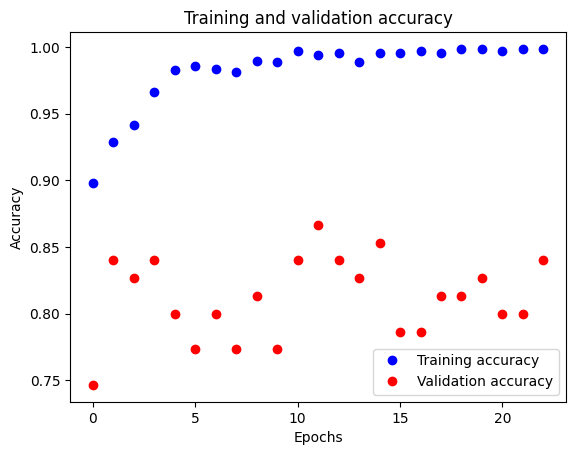

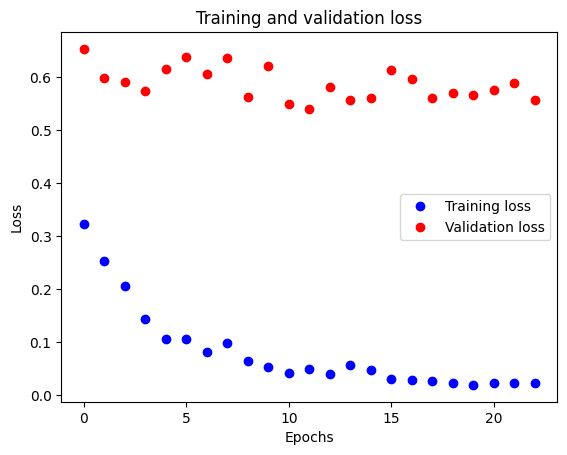

In [ ]:
# Evaluating Accuracy and Loss for the model for Level 2 Training
acc      = history_L2.history['acc']
val_acc  = history_L2.history['val_acc']
loss     = history_L2.history['loss' ]
val_loss = history_L2.history['val_loss']
epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.10 Saving the trained model

The model is saved as ‘5RuTanks_EfficientNetV2B3.h5’, and the current TensorFlow graph is cleared.

In [ ]:
model_file_name = '5RuTanks_EfficientNetV2B3.h5'
model.save(model_file_name)
print("Model successfully saved")

tf.keras.backend.clear_session() # Destroying the current TF graph - https://keras.io/backend/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model successfully saved


# Part 3: Analyzing the trained model:

## 3.1 Loading and validating the saved training model

The provided code snippet accomplishes the following:
It loads a saved Keras model from the file named ‘5RuTanks_EfficientNetV2B3.h5’ using tf.keras.models.load_model().
The summary of the loaded model architecture is displayed.
The model’s performance is evaluated on the validation data using evaluate(), resulting in validation loss (val_loss) and validation accuracy (val_acc).

In [ ]:
saved_model = tf.keras.models.load_model(model_file_name)
saved_model.summary()

print("\n### Validating the saved model ... ")
val_loss, val_acc = saved_model.evaluate(val_generator, steps=nbrValImages, verbose=1)
print('Test Results of the trained Model:\nVal loss:', val_loss, ",", 'Val accuracy:', val_acc)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 10, 10, 1536)      12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 batch_normalization (Batch  (None, 32)                128   

## 3.2 Saving validation images paths and true labes

The provided code snippet creates lists for validation image paths (val_images_paths), true labels (true_labels), and corresponding class names (true_labels_class). It iterates through each class, reads image files from the specified directory, and populates the lists accordingly. Finally, it prints the total number of saved validation image paths.

In [ ]:
val_images_paths = []
true_labels = []
true_labels_class = []

c = 0
for classname in classnames:
    val_images = os.listdir(val_images_path + classname + '/')
    for imagefile in val_images:
        val_images_paths.append(val_images_path + classname + '/' + imagefile)
        true_labels.append(c)
        true_labels_class.append(classname)
    c += 1

print(len(val_images_paths), "val images paths successfully saved")

75 val images paths successfully saved


## 3.3 predicting labels of val images with trained model

The provided code snippet predicts labels for the validation set using a trained model. It loads validation images, preprocesses them, and generates predicted labels. The total number of predicted labels and image tensors is printed.

In [ ]:
print("\n### predicting labels of the validation set with the trained model ... ")
pred_labels = []
img_tensors = []
for file in val_images_paths:
    img = tf.keras.preprocessing.image.load_img(file, target_size=(img_height, img_width))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = tf.keras.applications.efficientnet_v2.preprocess_input(img_tensor)
    img_tensors.append(img_tensor)
    pred_labels.append(saved_model.predict(img_tensor, verbose=0))

print(len(pred_labels), "predicted labels generated succesfully")
print(len(img_tensors), "image tensors generated succesfully")


### predicting labels of the validation set with the trained model ... 
75 predicted labels generated succesfully
75 image tensors generated succesfully


## 3.4 Confusion Matrix

The given code snippet imports the ConfusionMatrixDisplay class from sklearn.metrics and displays a confusion matrix for evaluating the performance of a classification model. The matrix is plotted with custom settings, including a larger figure size and vertical x-axis labels. The true labels and predicted labels are used to generate the display, along with class names. The title “Confusion Matrix” is added to the plot.


Confusion Matrix


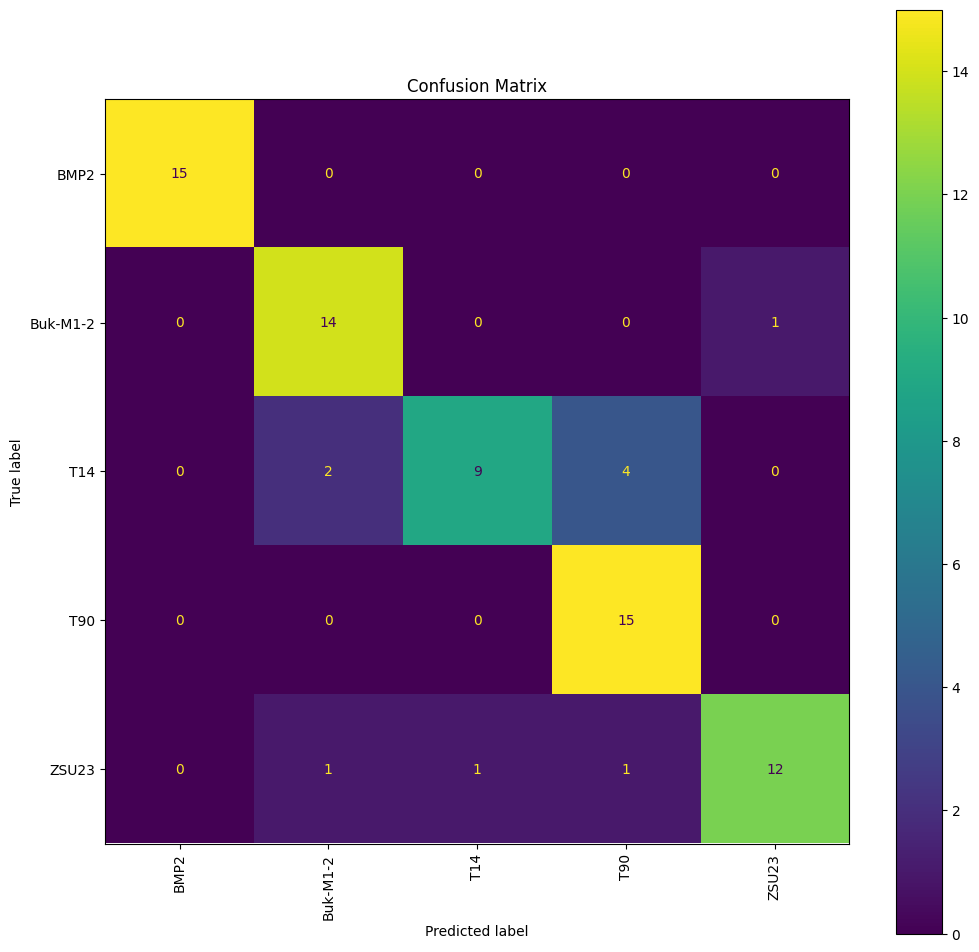

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
print('\nConfusion Matrix')
plt.rcParams['figure.figsize'] = [12, 12]
ConfusionMatrixDisplay.from_predictions(true_labels, np.argmax(pred_labels, axis=-1), display_labels=classnames, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

## 3.5 Classification Report

The code snippet provided demonstrates the use of classification_report function from scikit-learn. It generates a text report that includes key metrics such as precision, recall, F1-score, and support for each class.

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report')
print(classification_report(true_labels, np.argmax(pred_labels, axis=-1), target_names=classnames))


Classification Report
              precision    recall  f1-score   support

        BMP2       1.00      1.00      1.00        15
    Buk-M1-2       0.82      0.93      0.87        15
         T14       0.90      0.60      0.72        15
         T90       0.75      1.00      0.86        15
       ZSU23       0.92      0.80      0.86        15

    accuracy                           0.87        75
   macro avg       0.88      0.87      0.86        75
weighted avg       0.88      0.87      0.86        75



## 3.6  t-Distributed Stochastic Neighbor Embedding.

The code snippet provided demonstrates the use of t-SNE (t-Distributed Stochastic Neighbor Embedding) for visualizing high-dimensional data.

t-SNE is a dimensionality reduction technique that converts similarities between data points into joint probabilities. It aims to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the original high-dimensional data. Unlike some other methods, t-SNE’s cost function is not convex, meaning different initializations can yield different results. It’s recommended to reduce the number of dimensions using techniques like PCA or TruncatedSVD before applying t-SNE to high-dimensional data.

img_tensors.shape= (75, 300, 300, 3)
3/3 [==============================] - 5s 408ms/step
activations.shape= (75, 5)

 t-Distributed Stochastic Neighbor Embedding


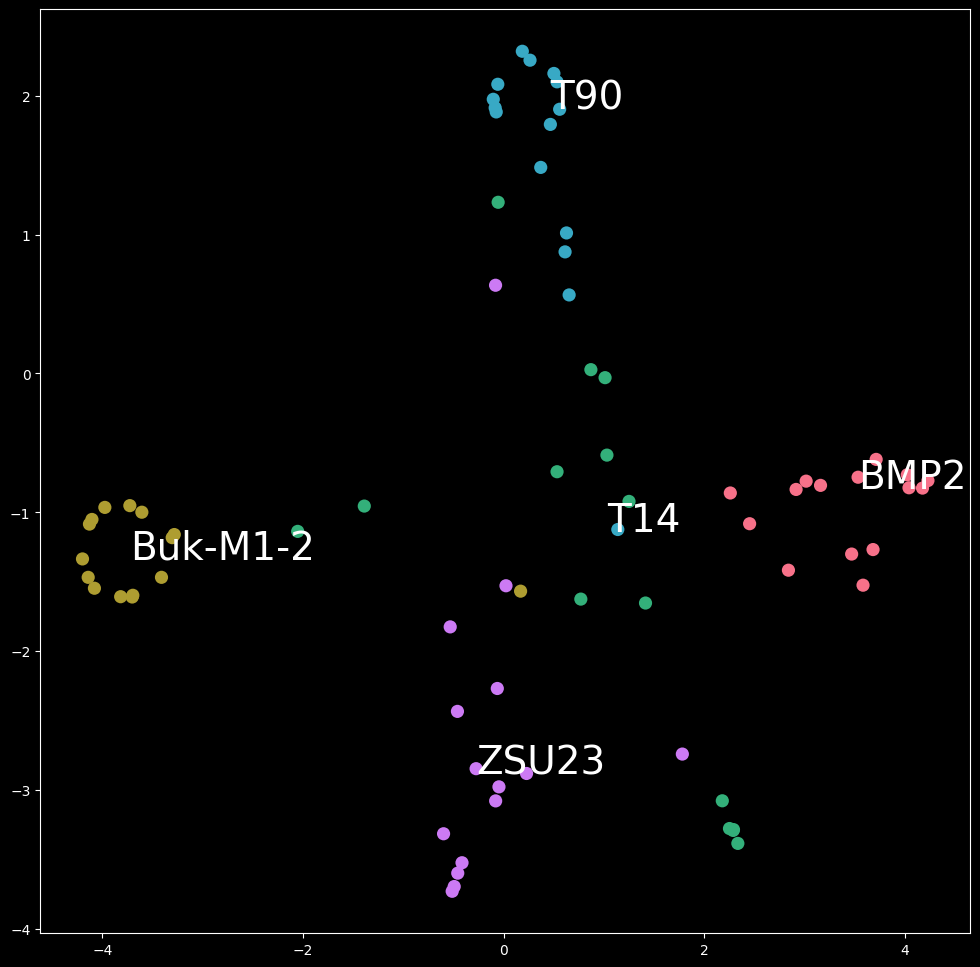

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# t-SNE Visualization: t-Distributed Stochastic Neighbor Embedding (t-SNE) for visualizing high-dimensional data.
layer = saved_model.get_layer(index=len(saved_model.layers)-1) # get last layer by index, use model.get_layer('dense_1') to get last layer by string.
layer_output = layer.output
activation_model = tf.keras.models.Model(inputs=saved_model.input, outputs=[layer_output])

img_tensors = np.array(img_tensors)
img_tensors = np.concatenate(img_tensors)
print("img_tensors.shape=", img_tensors.shape)

activations = activation_model.predict(img_tensors)
print("activations.shape=", activations.shape)

print("\n t-Distributed Stochastic Neighbor Embedding")
tsne = TSNE(random_state=86).fit_transform(activations)

# Visualization of the feature vectors produce by the convnet
palette = np.array(sns.color_palette("husl", len(classnames)))
true_labels = np.array(true_labels)

# create a scatter plot.
fig = plt.figure(figsize=(12, 12))
fig.patch.set_facecolor('black')
plt.style.use('dark_background')
plt.scatter(tsne[:, 0], tsne[:, 1], lw=0, s=90, c=palette[true_labels])
plt.axis('tight')

txts = []
for j in range(len(classnames)):
    # Position of each label at median of data points.
    xtext, ytext = np.median(tsne[true_labels == j, :], axis=0)
    txt = plt.text(xtext, ytext, classnames[j], fontsize=28, color = 'w')
    txts.append(txt)
plt.show()

## 3.7 Plotting all test images with class predictions as title

The provided code snippet prints the class predictions for validation images.

In [ ]:
print("\nClass Predictions of validation images")
for k in range(len(val_images_paths)): # For all images
    predictions = []
    for l in range(len(classnames)):
        predictions.append((np.round(pred_labels[k][0][l] * 100, 2), classnames[l]))
    predictions.sort(reverse=True)
    print('\n',"Image", k + 1, ":", predictions)

    plt.figure(figsize=(10, 10))  # width, height in inches.
    plt.style.use('dark_background')
    plt.suptitle("Class prediction of a " + true_labels_class[k] + " validation image", fontsize=16, color='r')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    legend_string = "Prediction: " + \
                    "\n%.2f" % predictions[0][0] + "% " + predictions[0][1] + \
                    "\n%.2f" % predictions[1][0] + "% " + predictions[1][1] + \
                    "\n%.2f" % predictions[2][0] + "% " + predictions[2][1] + \
                    "\n%.2f" % predictions[3][0] + "% " + predictions[3][1] + \
                    "\n%.2f" % predictions[4][0] + "% " + predictions[4][1]
    plt.text(img_width, img_height/2, legend_string, fontsize=16, color='r')
    plt.imshow(mpimg.imread(val_images_paths[k]))
    plt.show()

## 3.8 Uploading more images to further testing the model.

The provided code snippet defines a function called classify_image that predicts the class of an image using the trained model.

In [ ]:
from imageio.v2 import imread
def classify_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.array([img_tensor]) # Converts single image to a batch.
    img_tensor = tf.keras.applications.efficientnet_v2.preprocess_input(img_tensor)
    prediction = saved_model.predict(img_tensor, verbose=0)

    print(classnames[0], str(prediction[0][0]) +', '+
          classnames[1], str(prediction[0][1]) +', '+
          classnames[2], str(prediction[0][2]) +', '+
          classnames[3], str(prediction[0][3]) +', '+
          classnames[4], str(prediction[0][4]))

    if np.argmax(prediction) == 0:
        print("predicted class for image", img_path, ": " + classnames[0] + " with " + str(np.round(prediction[0][0] * 100, 2)) + "% accuracy")
    if np.argmax(prediction) == 1:
        print("predicted class for image", img_path, ": " + classnames[1] + " with " + str(np.round(prediction[0][1] * 100, 2)) + "% accuracy")
    if np.argmax(prediction) == 2:
        print("predicted class for image", img_path, ": " + classnames[2] + " with " + str(np.round(prediction[0][2] * 100, 2)) + "% accuracy")
    if np.argmax(prediction) == 3:
        print("predicted class for image", img_path, ": " + classnames[3] + " with " + str(np.round(prediction[0][3] * 100, 2)) + "% accuracy")
    if np.argmax(prediction) == 4:
        print("predicted class for image", img_path, ": " + classnames[4] + " with " + str(np.round(prediction[0][4] * 100, 2)) + "% accuracy")

    plt.figure(figsize=(10, 10))
    plt.imshow(plt.imread(img_path))
    plt.title(classnames[np.argmax(prediction)] + ': ' + str(np.round(prediction[0][np.argmax(prediction)] *100, 2)) + "% accuracy")
    plt.show()

    print('\n' + "The models perception of the image in " + str(img_height) + 'x ' + str(img_width))
    plt.imshow(img)
    plt.show()

The code below downloads images from the specified URLs, saves them, and then attempts to classify their content using the classify_image() function from above.


classifying image BMP-2_01.jpg retrived from https://upload.wikimedia.org/wikipedia/commons/1/1d/BMP-2_01.jpg
BMP2 0.83567387, Buk-M1-2 0.030755933, T14 0.015088227, T90 0.093154356, ZSU23 0.025327628
predicted class for image BMP-2_01.jpg : BMP2 with 83.57% accuracy


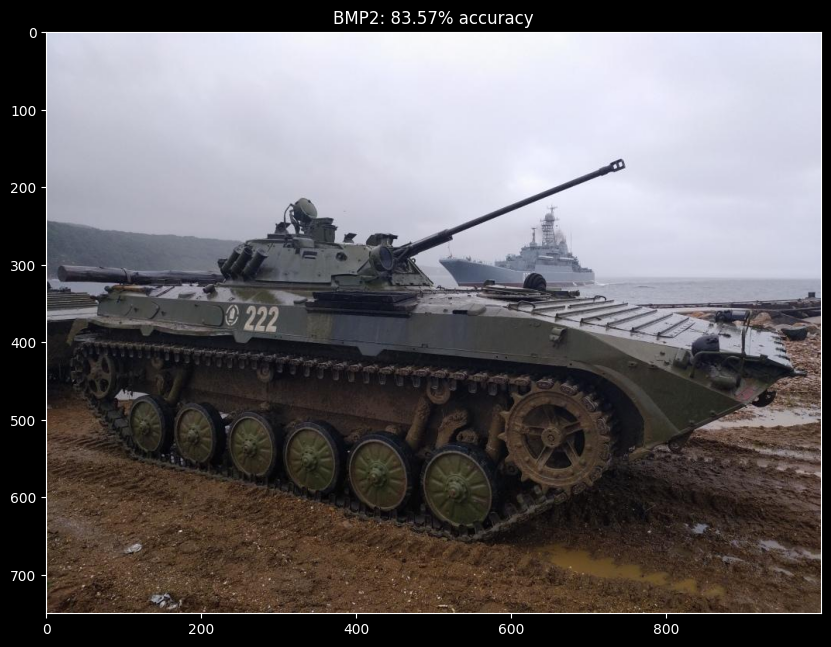


The models perception of the image in 300x 300


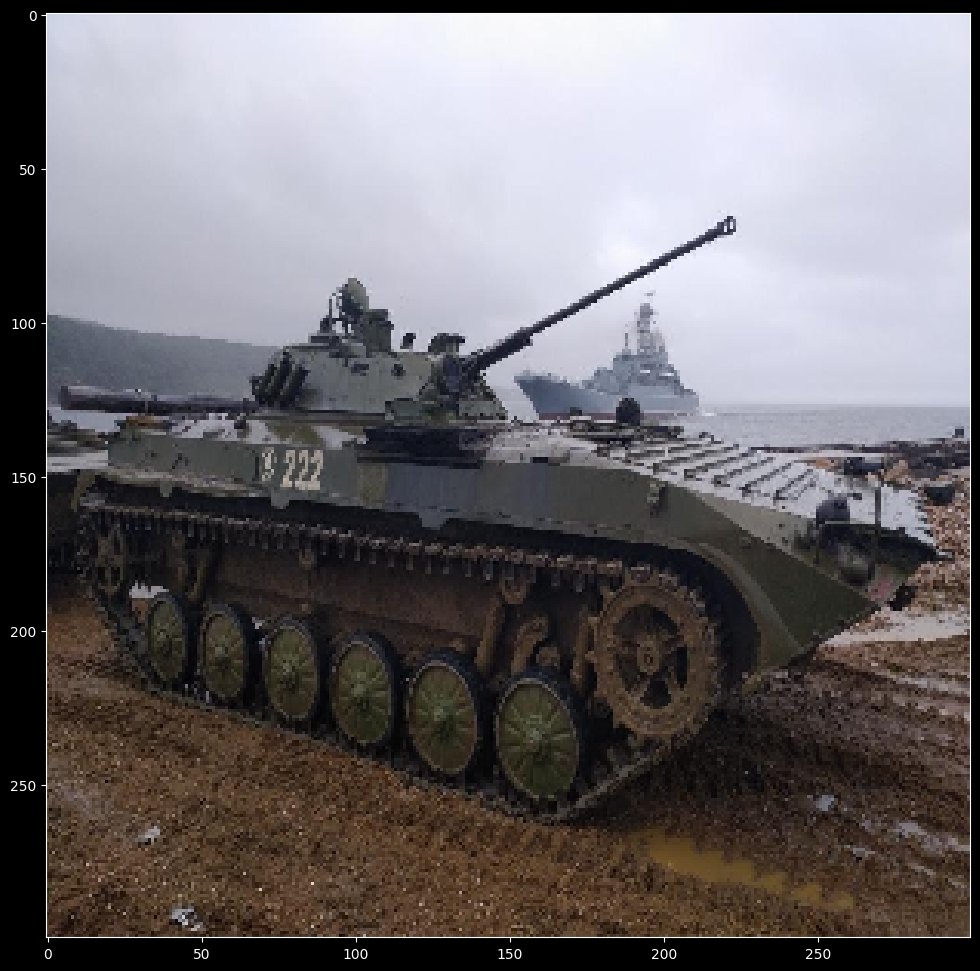


classifying image T-90-ET_2010.jpg retrived from https://upload.wikimedia.org/wikipedia/commons/3/3e/T-90-ET_2010.jpg
BMP2 0.016514761, Buk-M1-2 0.04030232, T14 0.075066276, T90 0.8273961, ZSU23 0.04072052
predicted class for image T-90-ET_2010.jpg : T90 with 82.74% accuracy


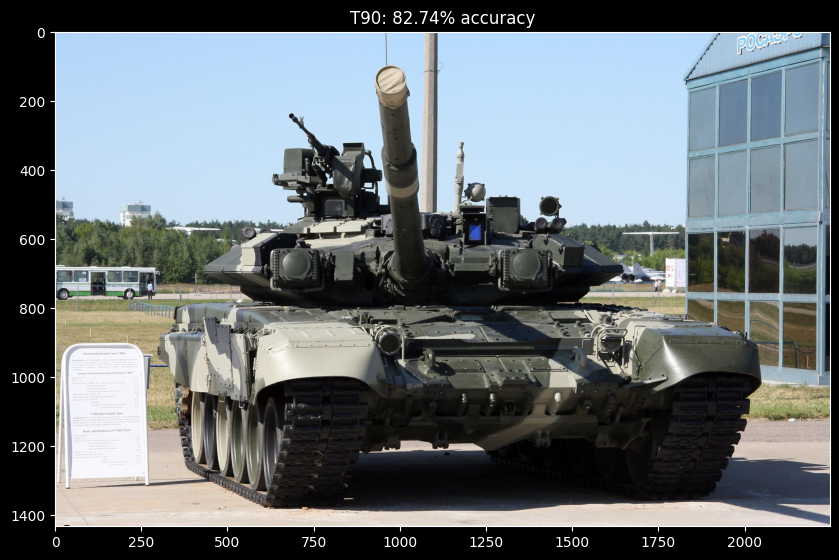


The models perception of the image in 300x 300


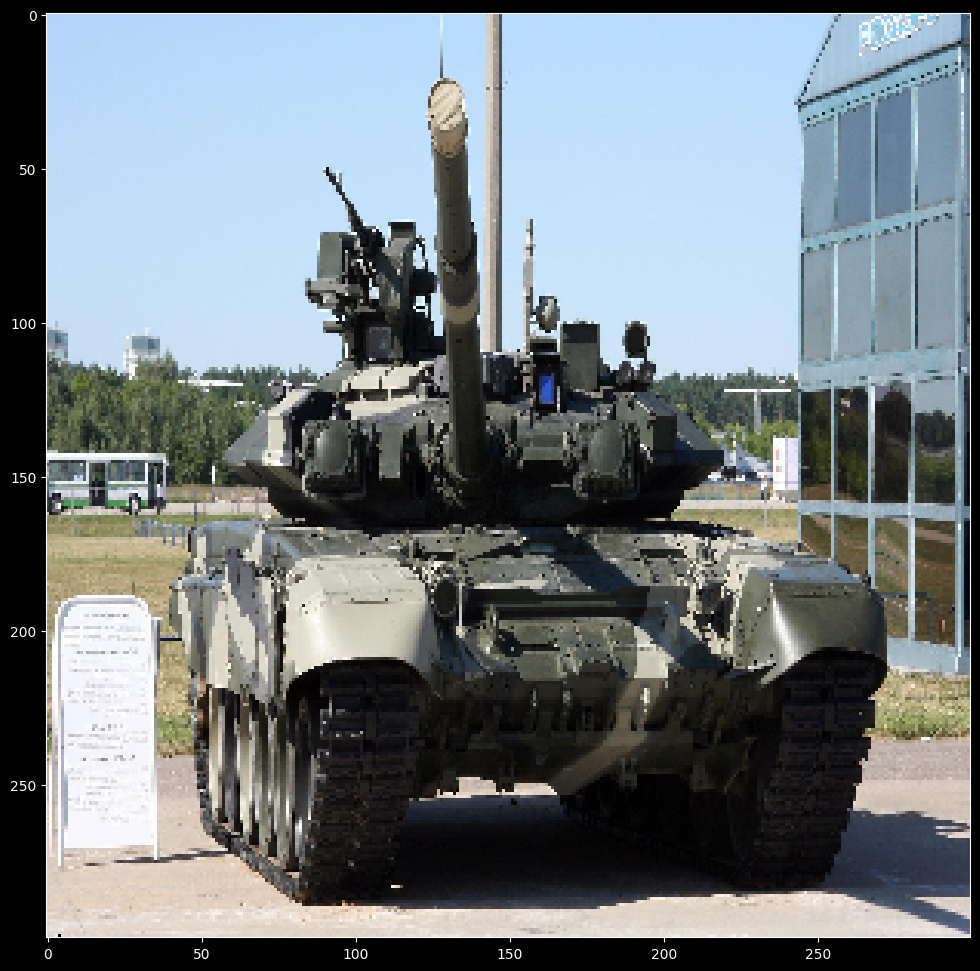

In [ ]:
Test_images = [
    ['https://upload.wikimedia.org/wikipedia/commons/1/1d/BMP-2_01.jpg', 'BMP-2_01.jpg'], # Ministry of Defence of the Russian Federation via Wikimedia Commons [https://commons.wikimedia.org/wiki/File:BMP-2_01.jpg]
    ['https://upload.wikimedia.org/wikipedia/commons/3/3e/T-90-ET_2010.jpg','T-90-ET_2010.jpg'], # Vitaly V. Kuzmin via via Wikimedia Commons [https://commons.wikimedia.org/wiki/File:T-90-ET_2010.jpg]
    ]

for image in Test_images:
    image_URL = image[0] # Provide a link to an image file
    img_name = image[1] # the name of the image file
    plt.imsave(img_name, imread(image_URL)) # saves the image in the colab environment
    print('')
    print('classifying image ' + img_name + ' retrived from ' + image_URL)
    classify_image(img_name)


## 4. References:

* TensorFlow: https://www.tensorflow.org/
* Keras: https://keras.io/api/applications/efficientnet_v2/
* Keras: https://keras.io/preprocessing/image/
* Keras: https://keras.io/guides/transfer_learning/
* Keras: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
* Keras: https://keras.io/preprocessing/image/
* Chollet, F. (2018). Deep learning with Python. Using a pretrained convnet. p. 143-159.

* Datacamp: https://www.datacamp.com/community/tutorials/introduction-t-sne

## Image References:

**BMP-2 validation Images:**
- [Validation Image 1](https://commons.wikimedia.org/wiki/File:BMP-2.JPG), posted by Termos, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 2](https://de.m.wikipedia.org/wiki/Datei:BMP-2_NVA.JPG), posted by Billyhill, licensed under [CC BY 3.0](https://creativecommons.org/licenses/by/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 3](https://en.wikipedia.org/wiki/File:Afghan_National_Army_BMP-2.JPEG), posted by U.S. Army, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 4](https://commons.wikimedia.org/wiki/File:BMP-2_military_parade_rehearsal.jpg), posted by Фальшивомонетчик , licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 5](https://commons.wikimedia.org/wiki/File:BMP-2_-_TankBiathlon14part1-12.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 6](https://de.wikipedia.org/wiki/Datei:BMP-2_Aberdeen_Proving_Ground.JPG), posted by Mark Pellegrini, licensed under [CC BY-SA 2.5](https://creativecommons.org/licenses/by-sa/2.5/deed.en), cropped to 331x331 pixels.
- [Validation Image 7](https://commons.wikimedia.org/wiki/File:BMP-2_-_TankBiathlon14part1-13.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 8](https://commons.wikimedia.org/wiki/File:BMP-2_near_Yavoriv,_Ukraine.jpg), posted by Staff Sgt. Adriana Diaz-Brown, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 9](https://commons.wikimedia.org/wiki/File:BMP-2_on_IMG-2017.jpg), posted by Mil.ru, licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 10](https://commons.wikimedia.org/wiki/File:Yudh_Abhyas-09_BMP.JPG), posted by Fred W. Baker III, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 11](https://commons.wikimedia.org/wiki/File:BMP-2_of_Russian_Ground_Forces.jpg), posted by Mil.ru, licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 12](https://commons.wikimedia.org/wiki/File:BMP-2_from_1983,_Bundeswehr_Military_History_Museum,_Dresden.jpg), posted by Stephencdickson, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 13](https://commons.wikimedia.org/wiki/File:Russian_BMP-2_IFV.jpg), posted by Jno, licensed under [CC BY-SA 1.0](https://creativecommons.org/licenses/by-sa/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 14](https://commons.wikimedia.org/wiki/File:BMP-2_2.JPG), posted by Mark Pellegrini, licensed under [CC BY-SA 2.5](https://creativecommons.org/licenses/by-sa/2.5/deed.en), cropped to 331x331 pixels.
- [Validation Image 15](https://commons.wikimedia.org/wiki/File:BMP-2_tank_at_the_Open_landmachtdagen_2010.jpg), posted by Alf van Beem, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.

**Buk-M1-2 validation Images:**
- [Validation Image 16](https://en.m.wikipedia.org/wiki/File:BUK_file1.jpg), posted by Stanislav Kozlovskiy, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 17](https://www.flickr.com/photos/df77/41253216854), posted by Dmitriy Fomin, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/), cropped to 331x331 pixels.
- [Validation Image 18](https://www.flickr.com/photos/df77/27053439937), posted by Dmitriy Fomin, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/), cropped to 331x331 pixels.
- [Validation Image 19](https://de.m.wikipedia.org/wiki/Datei:Buk-M1-2_9A310M1-2.jpg), posted by .:Ajvol:., licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 20](https://de.wikipedia.org/wiki/Datei:9K37_Buk_M1_SA-11_Gadfly.JPG), posted by Olli-Jukka Paloneva, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 21](https://commons.wikimedia.org/wiki/File:Buk-M2-MAKS-2007.jpg), posted by Участник:Xchgall, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 22](https://commons.wikimedia.org/wiki/File:ZRK_BUK_M1_2005_G1.jpg), posted by George Chernilevsky, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 23](https://commons.wikimedia.org/wiki/File:Buk-M2,_2009_Victory_parade.JPG), posted by piligrims74 (Anton), licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 24](https://commons.wikimedia.org/wiki/File:Buk-M1,_Kyiv_2018,_44.jpg), posted by VoidWanderer, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 25](https://en.wikipedia.org/wiki/File:2008_Moscow_Victory_Day_Parade_-_BUK_SAM.jpg), posted by Пользователь, licensed under [CC BY 3.0](https://creativecommons.org/licenses/by/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 26](https://commons.wikimedia.org/wiki/File:ZRK_BUK_M1_in_Vinnytsia_2016.jpg), posted by Vitaliy Trubnykov, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 27](https://commons.wikimedia.org/wiki/File:9A310_self-propelled_launch_vehicle_for_Buk-M1-2_Air_defence_system.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 28](https://commons.wikimedia.org/wiki/File:ParkPatriot2015part8-23.jpg), posted by  Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 29](https://commons.wikimedia.org/wiki/File:Engineering_Technologies_-_2012_(1-44).jpg), posted by  Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 30](https://commons.wikimedia.org/wiki/File:13April-Rehersal-Alabino-29.jpg), posted by  Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.

**T-14 validation Images:**
- [Validation Image 31](https://commons.wikimedia.org/wiki/File:T14-armata.jpg), posted by  Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 32](https://commons.wikimedia.org/wiki/File:Main_battle_tank_T-14_-_0-01.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 33](https://de.wikipedia.org/wiki/Datei:4mayrehearsal_09.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 34](https://commons.wikimedia.org/wiki/File:9may2015Moscow-01_(cropped).jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 35](https://commons.wikimedia.org/wiki/File:T-14_Armata_(41072263955).jpg), posted by Dmitriy Fomin, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 36](https://commons.wikimedia.org/wiki/File:%D0%A2%D0%B0%D0%BD%D0%BA_%C2%AB%D0%90%D1%80%D0%BC%D0%B0%D1%82%D0%B0%C2%BB_%D0%A2-14.JPG), posted by Соколрус, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 37](https://commons.wikimedia.org/wiki/File:T-14_Armata_(27053434067).jpg), posted by Dmitriy Fomin, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 38](https://commons.wikimedia.org/wiki/File:T-14_Armata_(41072270525).jpg), posted by Dmitriy Fomin, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 39](https://commons.wikimedia.org/wiki/File:T-14_prototype_from_above.JPG), posted by Boevaya mashina, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 40](https://commons.wikimedia.org/wiki/File:Main_battle_tank_T-14_-_0-03.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 41](https://commons.wikimedia.org/wiki/File:Main_battle_tank_T-14_-_0-02.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 42](https://commons.wikimedia.org/wiki/File:T-14_Armia_2018.jpg), posted by Boevaya mashina, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 43](https://commons.wikimedia.org/wiki/File:T-14_Armia_2018_(2).jpg), posted by Boevaya mashina, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 44](https://commons.wikimedia.org/wiki/File:9may2015Moscow-02_(cropped).jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 45](https://commons.wikimedia.org/wiki/File:%D0%A2%D0%B0%D0%BD%D0%BA_%D0%90%D1%80%D0%BC%D0%B0%D1%82%D0%B0_%D0%A2-14.jpeg), posted by Plutonium, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.

**T-90 validation Images:**
- [Validation Image 46](https://commons.wikimedia.org/wiki/File:T90-0010.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 47](https://commons.wikimedia.org/wiki/File:T-90A_MBT_photo010.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 48](https://commons.wikimedia.org/wiki/File:T-90A_-_Engineering_Technologies_2012_-01.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 49](https://commons.wikimedia.org/wiki/File:T-90_(5).jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 50](https://commons.wikimedia.org/wiki/File:T-90-ET_2010.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 51](https://en.wikipedia.org/wiki/File:T-90_main_battle_tank_(2).jpg), posted by Jno, licensed under [CC BY-SA 1.0](https://creativecommons.org/licenses/by-sa/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 52](https://de.wikipedia.org/wiki/Datei:Azeri_T-90,_parad_in_Baku,_2013.JPG), posted by Rorsah-photo, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 53](https://commons.wikimedia.org/wiki/File:T-90A_MBT_photo009.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 54](https://commons.wikimedia.org/wiki/File:T-90S_(4716212155).jpg), posted by Dmitry Terekhov, licensed under [CC BY-SA 2.0](https://creativecommons.org/licenses/by-sa/2.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 55](https://commons.wikimedia.org/wiki/File:T-90_(6).jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 56](https://commons.wikimedia.org/wiki/File:T-90S_0032_copy.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 57](https://commons.wikimedia.org/wiki/File:T-90_Bhisma.jpg), posted by cell105, licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 58](https://commons.wikimedia.org/wiki/File:T-90A_12april_Alabino_02.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 59](https://commons.wikimedia.org/wiki/File:T-90_(2).jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 60](https://commons.wikimedia.org/wiki/File:2008_Moscow_May_Parade_Rehearsal_-_T-90_tanks.JPG), posted by Vovan, licensed under [CC BY 3.0](https://creativecommons.org/licenses/by/3.0/deed.en), cropped to 331x331 pixels.

**ZSU-23-4 validation Images:**
- [Validation Image 61](https://commons.wikimedia.org/wiki/File:ZSU-23-4_Shilka_01.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 62](https://commons.wikimedia.org/wiki/File:ZSU_23-4_%22Shilka%22_mobile_anti-aircraft_vehicle_-_Museum_of_Army_Flying,_Hampshire,_England.jpg), posted by Acabashi, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 63](https://commons.wikimedia.org/wiki/File:ZSU-23-4_Shilka_03.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 64](https://en.wikipedia.org/wiki/File:Zsu-23-4-radar.jpg), posted by the U.S. military, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/), cropped to 331x331 pixels.
- [Validation Image 65](https://commons.wikimedia.org/wiki/File:ZSU-23-4_Shilka_05.jpg), posted by Vitaly V. Kuzmin, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 66](https://de.wikipedia.org/wiki/Datei:ZSU_23-4.JPG), posted by Davric, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/), cropped to 331x331 pixels.
- [Validation Image 67](https://commons.wikimedia.org/wiki/File:ZSU-23-4_Shilka,_Togliatti,_Russia-4.JPG), posted by ShinePhantom, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 68](https://commons.wikimedia.org/wiki/File:ZSU-23-4.jpg), posted by the U.S. Air Force, licensed under [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/), cropped to 331x331 pixels.
- [Validation Image 69](https://de.wikipedia.org/wiki/Datei:ZU-23-4-Shilka-hatzerim-1-1.jpg), posted by Bukvoed, licensed under [CC BY 2.5](https://creativecommons.org/licenses/by/2.5/deed.de), cropped to 331x331 pixels.
- [Validation Image 70](https://commons.wikimedia.org/wiki/File:Latrun_220917_ZSU-23-4.jpg), posted by Oren Rozen, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 71](https://de.wikipedia.org/wiki/Datei:Zsu-26-4-scotland.jpg), posted by Wo st 01/Wikipedia, licensed under [CC BY-SA 3.0 DE](https://creativecommons.org/licenses/by-sa/3.0/de/deed.en), cropped to 331x331 pixels.
- [Validation Image 72](https://commons.wikimedia.org/wiki/File:ZSU-23-4_Szy%C5%82ka_SPAAG_at_the_Muzeum_Polskiej_Techniki_Wojskowej_in_Warsaw.jpg), posted by SuperTank17, licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 73](https://commons.wikimedia.org/wiki/File:ZSU-23-4M4_Shilka-M4_Armia2018.jpg), posted by Boevaya mashina, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 74](https://commons.wikimedia.org/wiki/File:Vietnamese_ZSU-23-4.jpg), posted by Hoangprs5, licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.en), cropped to 331x331 pixels.
- [Validation Image 75](https://commons.wikimedia.org/wiki/File:Shilka.jpg), posted by the Ministry of Defense of Ukraine, licensed under [CC BY-SA 2.0](https://creativecommons.org/licenses/by-sa/2.0/deed.en), cropped to 331x331 pixels.

**Test Images:**

- [Test image 1](https://commons.wikimedia.org/wiki/File:BMP-2_01.jpg), posted by Ministry of Defence of the Russian Federation via Wikimedia Commons, licensed under [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/)

- [Test image 2](https://commons.wikimedia.org/wiki/File:T-90-ET_2010.jpg), posted by Vitaly V. Kuzmin via Wikimedia Commons, licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/deed.en)

## License:
Copyright (c) 2024 Ugur Uysal

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Thank you. Visit my personal GitHub page https://github.com/UgurUysal86 for more examples.